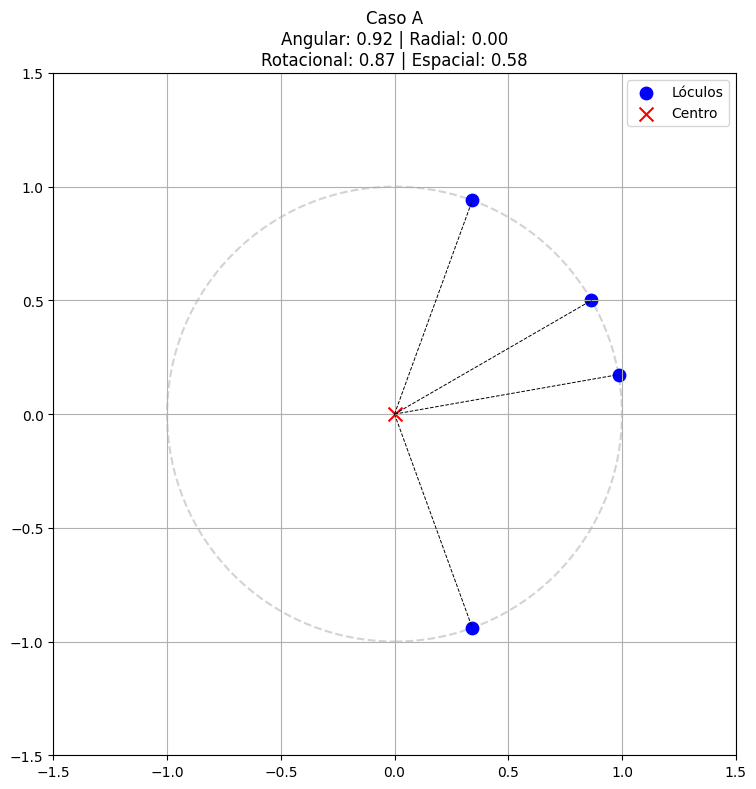

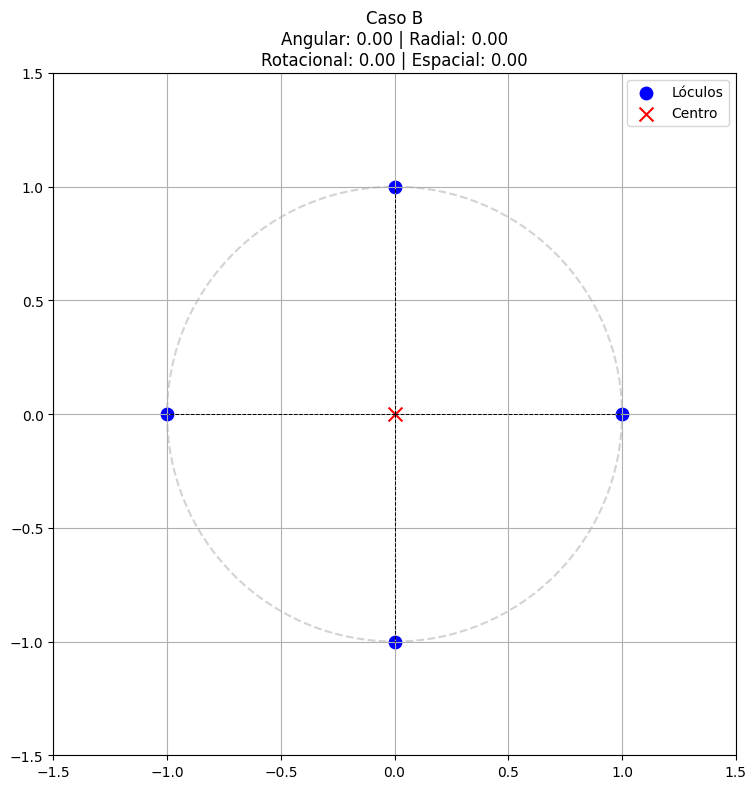

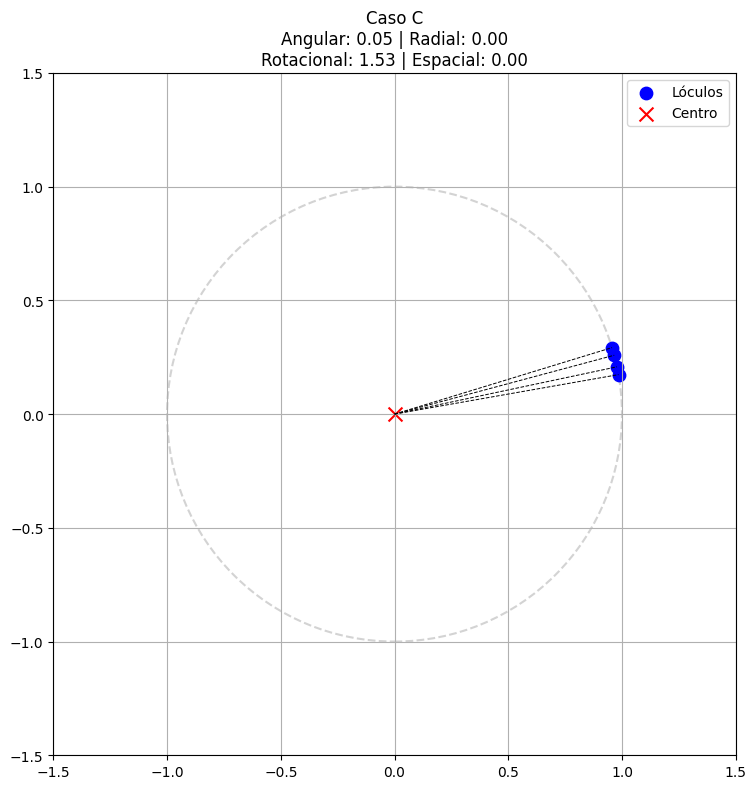

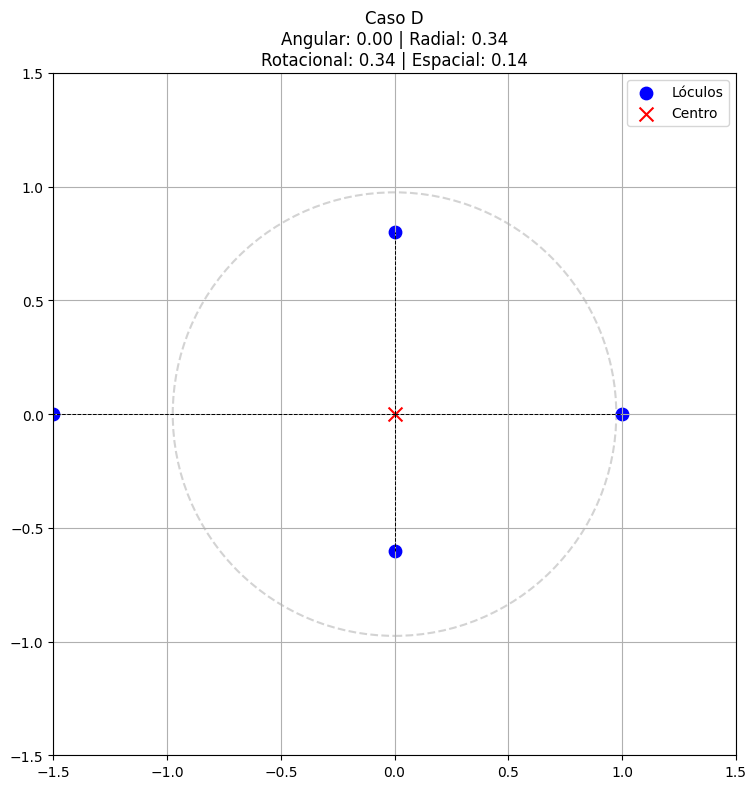

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import circstd
from scipy.spatial import distance

# -------------------------------
# Funciones de simetría
# -------------------------------

def angular_symmetry(locules, center):
    """Simetría angular: circular std de los ángulos (uniformidad angular)"""
    angles = []
    for cx, cy in locules:
        dx, dy = cx - center[0], cy - center[1]
        angle = math.atan2(dy, dx) % (2 * np.pi)
        angles.append(angle)
    
    if len(angles) < 2:
        return float('nan')
    
    # Detección explícita de simetría perfecta
    n = len(angles)
    expected = np.linspace(0, 2*np.pi, n, endpoint=False)
    if np.allclose(np.sort(angles), expected, atol=1e-8):
        return 0.0
    
    return circstd(angles)

def rotational_symmetry(locules, center):
    """Simetría rotacional: error vs distribución perfectamente equiespaciada"""
    polar_coords = []
    for cx, cy in locules:
        dx, dy = cx - center[0], cy - center[1]
        angle = math.atan2(dy, dx) % (2 * np.pi)
        radius = math.hypot(dx, dy)
        polar_coords.append((angle, radius))
    
    
    n = len(polar_coords)
    if n < 2:
        return float('nan')
    
    angles, radii = zip(*sorted(polar_coords, key=lambda x: x[0]))
    radii = np.array(radii) / np.mean(radii)  # Normalize
    
    expected_angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    min_error = float('inf')
    
    for shift in np.linspace(0, 2*np.pi, 360):
        shifted_angles = (np.array(angles) + shift) % (2 * np.pi)
        angle_error = np.mean(np.minimum(
            np.abs(shifted_angles - expected_angles),
            2*np.pi - np.abs(shifted_angles - expected_angles)
        ))
        radius_error = np.std(radii)
        total_error = angle_error + radius_error
        if total_error < min_error:
            min_error = total_error
    
    return min_error


def radial_symmetry(locules_data, centroid):
    distances = []
    for cx, cy in locules_data:
        distances.append(math.hypot(cx - centroid[0], cy - centroid[1]))
    # ...

    if len(distances) < 2:
        return float('nan')
    return np.std(distances) / np.mean(distances)

def spatial_symmetry(locules):
    """Simetría espacial: regularidad en distancias entre lóculos vecinos"""
    if len(locules) < 3:
        return float('nan')
    
    dist_matrix = distance.cdist(locules, locules)
    np.fill_diagonal(dist_matrix, np.inf)  # Ignorar distancia a sí mismo
    min_dists = np.min(dist_matrix, axis=1)  # Distancia al vecino más cercano
    
    return np.std(min_dists) / np.mean(min_dists)  # CV de distancias entre vecinos



def analyze_pattern(locules, center=(0, 0)):
    """Calcula todas las métricas de simetría"""
    return {
        'angular': angular_symmetry(locules, center),
        'radial': radial_symmetry(locules, center),
        'rotational': rotational_symmetry(locules, center),
        'spatial': spatial_symmetry(locules)
    }

# -------------------------------
# Visualización
# -------------------------------

def plot_pattern(locules, title, center=(0, 0)):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    
    # Radio promedio para el círculo guía
    avg_radius = np.mean([math.hypot(cx-center[0], cy-center[1]) for cx,cy in locules])
    
    # Círculo guía
    ax.add_patch(plt.Circle(center, avg_radius, color='lightgray', fill=False, ls='--', lw=1.5))
    
    # Lóculos y centro
    ax.scatter(*zip(*locules), color='blue', s=80, label='Lóculos')
    ax.scatter(*center, color='red', s=100, marker='x', label='Centro')
    
    # Líneas al centro
    for cx, cy in locules:
        ax.plot([center[0], cx], [center[1], cy], 'k--', lw=0.7)
    
    # Configuración
    ax.set_title(title, fontsize=12)
    ax.legend()
    ax.grid(True)
    ax.set_xlim(center[0]-1.5, center[0]+1.5)
    ax.set_ylim(center[1]-1.5, center[1]+1.5)
    plt.tight_layout()



# -------------------------------
# Casos de prueba
# -------------------------------

center = (0, 0)


# Caso A: Dispersión irregular
angles_a = np.deg2rad([10, 30, 70, 290])
locules_a = [(math.cos(a), math.sin(a)) for a in angles_a]
sym_a = analyze_pattern(locules_a)
label_a = (
    f"Caso A\n"
    f"Angular: {sym_a['angular']:.2f} | Radial: {sym_a['radial']:.2f}\n"
    f"Rotacional: {sym_a['rotational']:.2f} | Espacial: {sym_a['spatial']:.2f}"
)
plot_pattern(locules_a, label_a)

# Caso B: Simetría perfecta
angles_b = np.deg2rad([0, 90, 180, 270])
locules_b = [(math.cos(a), math.sin(a)) for a in angles_b]
sym_b = analyze_pattern(locules_b)
label_b = (
    f"Caso B\n"
    f"Angular: {sym_b['angular']:.2f} | Radial: {sym_b['radial']:.2f}\n"
    f"Rotacional: {sym_b['rotational']:.2f} | Espacial: {sym_b['spatial']:.2f}"
)
plot_pattern(locules_b, label_b)

# Caso C: Agrupamiento angular
angles_c = np.deg2rad([10, 12, 15, 17])
locules_c = [(math.cos(a), math.sin(a)) for a in angles_c]
sym_c = analyze_pattern(locules_c)
label_c = (
    f"Caso C\n"
    f"Angular: {sym_c['angular']:.2f} | Radial: {sym_c['radial']:.2f}\n"
    f"Rotacional: {sym_c['rotational']:.2f} | Espacial: {sym_c['spatial']:.2f}"
)
plot_pattern(locules_c, label_c)

# Caso D: Variación radial
angles_d = np.deg2rad([0, 90, 180, 270])
radii_d = [1.0, 0.8, 1.5, 0.6]  # diferentes radios
locules_d = [(r * math.cos(a), r * math.sin(a)) for a, r in zip(angles_d, radii_d)]
sym_d = analyze_pattern(locules_d)
label_d = (
    f"Caso D\n"
    f"Angular: {sym_d['angular']:.2f} | Radial: {sym_d['radial']:.2f}\n"
    f"Rotacional: {sym_d['rotational']:.2f} | Espacial: {sym_d['spatial']:.2f}"
)
plot_pattern(locules_d, label_d)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import circstd
from scipy.spatial import distance
import cv2
from sklearn.neighbors import NearestNeighbors

#################################################################################################
# Precalculates and stores geometric data
#################################################################################################

def precalculate_locules_data(contours, locules):
    """ 
    Precalculates and stores geometric data about locules from image contours.
    Args:
        contours (List[np.ndarray]): List of contour points (OpenCV format).
        locules (List[int]): Indices of contours that represent locules.
    Returns:
        List[Dict]: List of dictionaries with locule data (centroid, area, perimeter, contour).
    """
    locules_data = []
    for locule in locules:
        M = cv2.moments(contours[locule])
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            area = cv2.contourArea(contours[locule])
            perimeter = cv2.arcLength(contours[locule], True)
            
            locules_data.append({
                'centroid': (cx, cy),
                'area': area,
                'perimeter': perimeter,
                'contour': contours[locule]
            })
    return locules_data

#################################################################################################
# Angular symmetry (similar a tu versión original pero mejorada)
#################################################################################################

import numpy as np
import math
from scipy.stats import circstd

def angular_symmetry(locules, center):
    """Calcula la simetría angular de un conjunto de loculos con respecto a un centro.

    Args:
        locules (List[Tuple[float, float]]): Lista de centroides (x,y) de los loculos.
        center (Tuple[float, float]): Centro de referencia (x,y).

    Returns:
        float: Desviación circular de los ángulos rotados (0 = simetría perfecta).
    """
    n = len(locules)
    if n < 2:
        return float('nan')

    # Calcula los ángulos relativos al centro
    angles = []
    for cx, cy in locules:
        dx, dy = cx - center[0], cy - center[1]
        angle = math.atan2(dy, dx) % (2 * np.pi)
        angles.append(angle)
    angles = np.array(angles)

    # Ángulos ideales equiespaciados
    ideal_angles = np.linspace(0, 2*np.pi, n, endpoint=False)

    # Para encontrar la rotación óptima que minimice la diferencia con los ideales
    # probamos varios desplazamientos y tomamos la mínima desviación circular
    rotations = np.linspace(0, 2*np.pi, 360, endpoint=False)
    min_circ_std = float('inf')
    for rot in rotations:
        rotated = (angles - rot) % (2*np.pi)
        # Ordenamos para comparar con ideal
        rotated_sorted = np.sort(rotated)
        diff = np.abs(rotated_sorted - ideal_angles)
        # Consideramos circularidad en la diferencia
        diff = np.minimum(diff, 2*np.pi - diff)

        # Si la diferencia máxima es muy pequeña (tolerancia), retornamos 0 (simetría perfecta)
        if np.max(diff) < 1e-6:
            return 0.0

        # Calculamos desviación circular
        std = circstd(rotated)
        if std < min_circ_std:
            min_circ_std = std

    return min_circ_std


#################################################################################################
# Radial symmetry (similar a tu original pero con CV)
#################################################################################################

def radial_symmetry_from_data(locules_data, centroid):
    """
    Calculate radial symmetry using coefficient of variation (CV) of distances.
    Args:
        locules_data: List of locule data.
        centroid: Reference center.
    Returns:
        float: CV of distances (0=perfect symmetry).
    """
    distances = []
    for data in locules_data:
        cx, cy = data['centroid']
        distances.append(math.hypot(cx - centroid[0], cy - centroid[1]))
    
    if len(distances) < 2:
        return float('nan')
    return np.std(distances) / np.mean(distances)

#################################################################################################
# Spatial symmetry (versión mejorada de tu original)
#################################################################################################

def spatial_symmetry_from_data(locules_data):
    """
    Calculate spatial symmetry using CV of nearest-neighbor distances + penalty.
    Args:
        locules_data: List of locule data.
    Returns:
        float: Regularity metric (0=perfect, high=clustered).
    """
    if len(locules_data) < 3:
        return float('nan')
    
    positions = [data['centroid'] for data in locules_data]
    dist_matrix = distance.cdist(positions, positions)
    np.fill_diagonal(dist_matrix, np.inf)
    min_dists = np.min(dist_matrix, axis=1)
    
    cv = np.std(min_dists) / np.mean(min_dists)
    mean_dist = np.mean(min_dists)
    return cv + (1 / mean_dist)  # Penalización por agrupamiento

#################################################################################################
# Rotational symmetry (nueva función, no estaba en tu original)
#################################################################################################

def rotational_symmetry_from_data(locules_data, centroid):
    """
    Calculate rotational symmetry error (angles + radii).
    Args:
        locules_data: List of locule data.
        centroid: Reference center.
    Returns:
        float: Error metric (0=perfect symmetry).
    """
    polar_coords = []
    for data in locules_data:
        cx, cy = data['centroid']
        dx, dy = cx - centroid[0], cy - centroid[1]
        angle = math.atan2(dy, dx) % (2 * np.pi)
        radius = math.hypot(dx, dy)
        polar_coords.append((angle, radius))
    
    n = len(polar_coords)
    if n < 2:
        return float('nan')
    
    angles, radii = zip(*sorted(polar_coords, key=lambda x: x[0]))
    radii = np.array(radii) / np.mean(radii)  # Normalize
    
    expected_angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    min_error = float('inf')
    
    for shift in np.linspace(0, 2*np.pi, 360):
        shifted_angles = (np.array(angles) + shift) % (2 * np.pi)
        angle_error = np.mean(np.minimum(
            np.abs(shifted_angles - expected_angles),
            2*np.pi - np.abs(shifted_angles - expected_angles)
        ))
        radius_error = np.std(radii)
        total_error = angle_error + radius_error
        if total_error < min_error:
            min_error = total_error
    
    return min_error

#################################################################################################
# Integrated analysis (similar a tu flujo original)
#################################################################################################

def analyze_locules_symmetry(contours, locule_indices, centroid):
    """
    Integrated symmetry analysis (wrapper for all metrics).
    Args:
        contours: OpenCV contours.
        locule_indices: Indices of locule contours.
        centroid: Reference center.
    Returns:
        Dict: Symmetry metrics.
    """
    locules_data = precalculate_locules_data(contours, locule_indices)
    return {
        'angular': angular_locules_symmetry(locules_data, centroid),
        'radial': radial_symmetry_from_data(locules_data, centroid),
        'rotational': rotational_symmetry_from_data(locules_data, centroid),
        'spatial': spatial_symmetry_from_data(locules_data)
    }

In [33]:
import numpy as np

def cv(distances):
    return np.std(distances) / np.mean(distances), np.std(distances)

# Misma σ, diferente CV
print(cv([5, 10, 15]))     # ≈ 0.408 (40.8%)
print(cv([95, 100, 105]))  # ≈ 0.0408 (4.08%)

# Misma σ y mismo CV (diferente escala)
print(cv([10, 20, 30]))    # ≈ 0.408
print(cv([100, 200, 300])) # ≈ 0.408

(0.408248290463863, 4.08248290463863)
(0.040824829046386304, 4.08248290463863)
(0.408248290463863, 8.16496580927726)
(0.4082482904638631, 81.64965809277261)


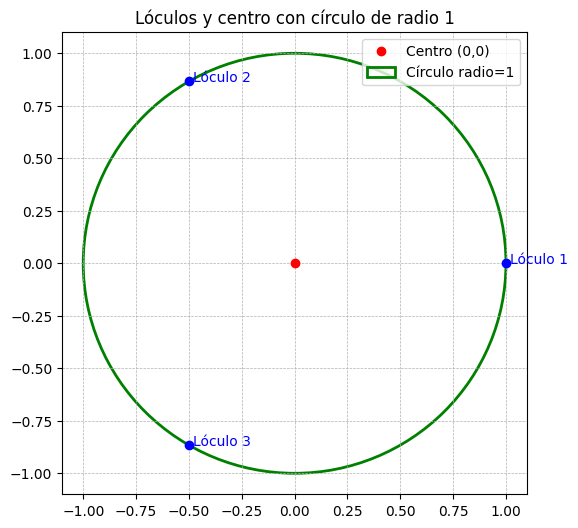

In [39]:
import matplotlib.pyplot as plt

# Datos
locules_data = [
    {'centroid': (1, 0)},      # Lóculo 1 (0°)
    {'centroid': (-0.5, 0.866)}, # Lóculo 2 (120°)
    {'centroid': (-0.5, -0.866)} # Lóculo 3 (240°)
]
centroid = (0, 0)

# Extraer coordenadas de los lóculos
locules_points = [locule['centroid'] for locule in locules_data]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(6,6))

# Dibujar cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Dibujar el punto centro
ax.plot(*centroid, 'ro', label='Centro (0,0)')

# Dibujar los lóculos
for i, (x, y) in enumerate(locules_points):
    ax.plot(x, y, 'bo')
    ax.text(x+0.02, y, f"Lóculo {i+1}", color='blue')

# Dibujar círculo con radio 1 alrededor del centro
circle = plt.Circle(centroid, 1, color='green', fill=False, linewidth=2, label='Círculo radio=1')
ax.add_patch(circle)

# Ajustar límites


# Título y leyenda
ax.set_title("Lóculos y centro con círculo de radio 1")
ax.legend()

plt.show()


In [ ]:
import numpy as np
import math
from scipy.fft import fft

def rotational_symmetry_optimized(locules_data, centroid):
    """
    Calculate an optimized rotational symmetry error combining angular and radial components.

    Args:
        locules_data (list): List of dictionaries, each with a 'centroid' key containing (x, y) coordinates.
        centroid (tuple): Reference center coordinates (x, y).

    Returns:
        float: Symmetry error metric (0 = perfect symmetry, higher values indicate less symmetry).
               Returns np.nan if fewer than 2 locules are provided or invalid data.
    """
    polar_coords = []
    for data in locules_data:
        cx, cy = data['centroid']
        dx, dy = cx - centroid[0], cy - centroid[1]
        angle = math.atan2(dy, dx) % (2 * np.pi)
        radius = math.hypot(dx, dy)
        polar_coords.append((angle, radius))
    
    n = len(polar_coords)
    if n < 2:
        return float('nan')
    
    # Sort by angle
    angles, radii = zip(*sorted(polar_coords, key=lambda x: x[0]))
    angles = np.array(angles)
    
    # Logarithmic smoothing of radii with epsilon for numerical stability
    radii = np.log1p(np.array(radii) + 1e-10)
    
    # Use FFT to find dominant rotational symmetry and best rotation shift
    complex_coords = np.exp(1j * angles)
    fft_coeffs = fft(complex_coords)
    # Ignore the zero-frequency term, search max magnitude in first half spectrum
    k = np.argmax(np.abs(fft_coeffs[1:(n//2 + 1)])) + 1
    shift = -np.angle(fft_coeffs[k]) / k
    shifted_angles = (angles + shift) % (2 * np.pi)
    
    # Expected perfectly symmetric angles
    expected_angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    
    # Angular error normalized between 0 and 1
    angle_diff = np.abs(shifted_angles - expected_angles)
    angle_error = np.mean(np.minimum(angle_diff, 2*np.pi - angle_diff)) / np.pi
    
    # Radial error based on differences between consecutive radii in sorted order
    max_radius = np.max(radii)
    if max_radius == 0:
        return float('nan')  # Cannot normalize radial differences
    
    radius_error = np.mean(np.abs(np.diff(radii, append=radii[0]))) / max_radius
    
    # Combined error using geometric mean to balance both terms
    total_error = np.sqrt(angle_error * radius_error)
    
    return total_error


In [45]:
#################################################################################################
# Precalculates and stores geometric data
#################################################################################################

def precalculate_locules_data(contours, locules, centroid):
    """ 
    Precalculates and stores geometric data about locules from image contours to optimize firther processing.

    Args:

        REQUIRED:
            - contours (List[np.ndarray]): List of contous points (OpenCV format).
            - locules (List[int]): Indices of contours that represent locules.
            - centroid (Tuple[int,int]): Reference centroid as a tuple (x,y).
 
    Returns:
        - locules_data (List[Dict]): A list of dictionaries, each containg:
            - 'centroid' (Tuple[int, int]): (x,y) coordinates of the locule's centroid.
            - 'area' (float): Area of the locule in pixels.
            - 'perimeter' (float): Perimeter of the locule in pixels.
            - 'contour' (np.ndarray): Original contour points.
            - 'polar_coords' (Tuple[float, float]): Pair of (angle_in_radians, radius) calculated relative to the reference centroid.
            - 'circularity' (float): Circularity of the locule contour in a range from 0 to 1, where 1 indicates a perfect circle and 0 a extreme imperfect shape.

    Notes:
        - Uses OpenCV moments for centroid calculation.
        - Skips contours with zero area (m00 = 0)
    """
    locules_data = [] # Initialize an empty list to store calculated data for each locule

    for locule in locules: # For each locule:
        M = cv2.moments(contours[locule]) # Calculate moments for the contour at index locule 
    
        if M["m00"] == 0: # If contour area is 0
            continue # skip
        
        ## Cartesian coordinates
        cx = int(M["m10"] / M["m00"]) # Calculate x-coordinates of centroid
        cy = int(M["m01"] / M["m00"]) # Calculate y-coordinates of centroid

        area = cv2.contourArea(contours[locule]) # Calculate the area of the locule 
        perimeter = cv2.arcLength(contours[locule], True) # Calculate the perimeter of the locule (True = Closed contour)


        ## Polar coordinates
        dx, dy = cx - centroid[0], cy - centroid[1] # Calculate the displacement vector from the reference centroid to the locule's centroid
        angle = math.atan2(dy, dx) % (2 * np.pi) # Calculate the angle (in radians) of this vector from the positive x-axis in [0,2pi] range.
        radius = math.hypot(dx, dy) # Calculate the Eucladian distance between the displacement vector

        ## Get perfect angles

        locules_data.append({ # Store calculated data in a dictionary
            'centroid': (cx, cy), # Centroid coordinates
            'area': area, # Area measurement
            'perimeter': perimeter, # Perimeter measurement
            'contour': contours[locule], # Original contour points
            'polar_coord': (angle, radius), # Angle and radius calculated relative to the reference centroid
            'circularity': (4 * np.pi * area) / (perimeter ** 2),  # 1.0 = perfect circle
            #'hu_moments': cv2.HuMoments(M).flatten()  # Hu invariant moments (7 values)
        })



    return locules_data

#################################################################################################
# Angular locule symmetry
#################################################################################################

import numpy as np
import math
from scipy.optimize import minimize_scalar

def angular_symmetry_equidistance(locules_data, return_normalized=True):
    """
    Measures how close locule angles are to an evenly spaced (n-fold) pattern.
    Uses a global rotation search (optimization) to align the pattern.

    Args:
        locules_data: list of dicts with 'centroid' or 'polar_coord'.
                      If 'polar_coord' present, it uses that angle; otherwise uses centroid.
        return_normalized: if True returns value in [0,1] (0 perfect), else returns mean angular error (radians).

    Returns:
        float: normalized error in [0,1] (or mean angular error in radians if return_normalized=False).
               Returns np.nan if <2 locules.
    """
    # Extract angles relative to the same center (we assume polar_coord precomputed)
    angles = []
    for d in locules_data:
        if 'polar_coord' in d:
            angles.append(d['polar_coord'][0] % (2*np.pi))
        else:
            cx, cy = d['centroid']
            # if no center provided in locules_data, you must ensure they are relative to the same center
            raise ValueError("locules_data items need 'polar_coord' or you must precompute angles.")
    angles = np.array(angles)
    n = len(angles)
    if n < 2:
        return np.nan

    ideal = np.linspace(0, 2*np.pi, n, endpoint=False)

    # objective: mean minimal angular diff between sorted rotated angles and ideal angles
    def mean_error(rot):
        rotated = (angles + rot) % (2*np.pi)
        rotated_sorted = np.sort(rotated)
        diffs = np.abs(rotated_sorted - ideal)
        diffs = np.minimum(diffs, 2*np.pi - diffs)  # shortest arc
        return np.mean(diffs)

    # minimize over rotation in [0, 2pi)
    res = minimize_scalar(mean_error, bounds=(0, 2*np.pi), method='bounded')
    mean_ang_err = res.fun  # in radians

    if not return_normalized:
        return mean_ang_err

    # normalize: divide by (pi/n) which is half-step angular (1 = worst reasonable average shift)
    max_expected = np.pi / n
    norm = min(mean_ang_err / max_expected, 1.0)
    return norm




#################################################################################################
# Radial locules symmetry
#################################################################################################

def radial_symmetry(locules_data):
    """
    Calculate radial symmetry using coefficient of variation (CV) of distances.
    Args:
        REQUIRED:
            - locules_data (List[Dict]): List of dictionaries, where each dictionary contains the centroid coordinates (x,y) of a locule and precalculated 'polar_coordinates'.


    Returns:
        float: CV of distances (0 = perfect symmetry, nan = undefined).
    """
    if len(locules_data) < 2: # If there is fewer than 2 locules, symettry is undefined (no symmetry) 
        return np.nan

    radii = [data['polar_coord'][1] for data in locules_data] # Extract precalculated radii for each locule's data
    
    return np.std(radii) / np.mean(radii) if np.mean(radii) > 0 else 0.0 # Compute coefficient of variation (CV = standard deviation / mean)


#################################################################################################
# Rotational symmetry 
#################################################################################################


def rotational_symmetry(locules_data, angle_weight=0.7, radius_weight=0.3, min_radius_threshold=0.1):
    """
    Calculates rotational symmetry using optimal matching (Hungarian algorithm) for n ≤ 20,
    and a greedy method for n > 20.
    
    Args:
        locules_data: List of dictionaries with 'polar_coord' = (angle, radius).
        angle_weight: Weight for angular error (default=0.7).
        radius_weight: Weight for radial error (default=0.3).
        min_radius_threshold: Ignore locules with radius < X% of the mean (default=10%).
    
    Returns:
        float: 0 = perfect symmetry, 1 = maximum theoretical asymmetry.
               np.nan if fewer than 2 valid locules.
    """
    if len(locules_data) < 2:  # If there is fewer than 2 locules, symmetry is undefined (no symmetry)
        return np.nan

    # Extract and sort polar coordinates (angle, radius) for each locule's data
    angles, radii = zip(*sorted([d['polar_coord'] for d in locules_data], key=lambda x: x[0]))
    
    angles = np.array(angles) % (2 * np.pi)  # Normalize angles to [0, 2π)
    radii = np.array(radii)
    radii_normalized = radii / np.mean(radii)  # Normalize radii by the average value (relative sizes matter more than absolute distances)
    
    # Filter out locules with radius smaller than threshold
    valid_mask = radii_normalized >= min_radius_threshold
    angles = angles[valid_mask]
    radii_normalized = radii_normalized[valid_mask]
    
    n = len(angles)  # Number of locules after filtering
    if n < 2:  # Symmetry undefined if fewer than 2 locules remain
        return np.nan

    # Generate equally spaced ideal angles (e.g. for 3 locules: [0, 2π/3, 4π/3])
    expected_angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
    # Compute cost matrix of angular differences between actual and ideal angles
    diff = np.abs(angles[:, None] - expected_angles[None, :])
    cost_matrix = np.minimum(diff, 2 * np.pi - diff)  # Account for circular wrap-around (shortest angular distance)
    
    # Use Hungarian algorithm for optimal assignment if n ≤ 20
    if n <= 20:
        row_ind, col_ind = linear_sum_assignment(cost_matrix)  # Find assignment minimizing total angular error
        angle_error = cost_matrix[row_ind, col_ind].mean()  # Average angular error over assigned pairs
    else:
        # For larger n, use greedy assignment to reduce computational cost
        used = set()
        angle_error = 0.0
        for i in np.argsort(np.min(cost_matrix, axis=1)):  # Process locules ordered by minimal cost
            j = np.argmin(cost_matrix[i])  # Find closest ideal angle not yet used
            if j not in used:
                angle_error += cost_matrix[i, j]  # Accumulate error
                used.add(j)
        angle_error /= n  # Average angular error
    
    max_angle_error = np.pi / n  # Maximum expected angular error (half the step angle between locules)
    angle_error_norm = min(angle_error / max_angle_error, 1.0)  # Normalize error to [0,1]
    
    # Calculate radial error robustly using Median Absolute Deviation (MAD)
    median_abs_dev = np.median(np.abs(radii_normalized - 1.0))
    radius_error_norm = np.tanh(median_abs_dev / 0.6745)  # Normalize radial error smoothly to ~[0,1)
    

    # Weighted combination of angular and radial errors
    total_weight = angle_weight + radius_weight
    combined_error = (angle_weight * angle_error_norm + radius_weight * radius_error_norm) / total_weight
    
    return np.clip(combined_error, 0.0, 1.0)  # Ensure result is within [0,1]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import psutil
from scipy.stats import circmean, circstd
from scipy.optimize import linear_sum_assignment

def precalculate_locules_data(contours, locules, centroid):
    """ 
    Precalculates and stores geometric data about locules from image contours to optimize firther processing.

    Args:

        REQUIRED:
            - contours (List[np.ndarray]): List of contous points (OpenCV format).
            - locules (List[int]): Indices of contours that represent locules.
            - centroid (Tuple[int,int]): Reference centroid as a tuple (x,y).
 
    Returns:
        - locules_data (List[Dict]): A list of dictionaries, each containg:
            - 'centroid' (Tuple[int, int]): (x,y) coordinates of the locule's centroid.
            - 'area' (float): Area of the locule in pixels.
            - 'perimeter' (float): Perimeter of the locule in pixels.
            - 'contour' (np.ndarray): Original contour points.
            - 'polar_coords' (Tuple[float, float]): Pair of (angle_in_radians, radius) calculated relative to the reference centroid.
            - 'circularity' (float): Circularity of the locule contour in a range from 0 to 1, where 1 indicates a perfect circle and 0 a extreme imperfect shape.

    Notes:
        - Uses OpenCV moments for centroid calculation.
        - Skips contours with zero area (m00 = 0)
    """
    locules_data = [] # Initialize an empty list to store calculated data for each locule

    for locule in locules: # For each locule:
        M = cv2.moments(contours[locule]) # Calculate moments for the contour at index locule 
    
        if M["m00"] == 0: # If contour area is 0
            continue # skip
        
        ## Cartesian coordinates
        cx = int(M["m10"] / M["m00"]) # Calculate x-coordinates of centroid
        cy = int(M["m01"] / M["m00"]) # Calculate y-coordinates of centroid

        area = cv2.contourArea(contours[locule]) # Calculate the area of the locule 
        perimeter = cv2.arcLength(contours[locule], True) # Calculate the perimeter of the locule (True = Closed contour)


        ## Polar coordinates
        dx, dy = cx - centroid[0], cy - centroid[1] # Calculate the displacement vector from the reference centroid to the locule's centroid
        angle = math.atan2(dy, dx) % (2 * np.pi) # Calculate the angle (in radians) of this vector from the positive x-axis in [0,2pi] range.
        radius = math.hypot(dx, dy) # Calculate the Eucladian distance between the displacement vector

        ## Get perfect angles

        locules_data.append({ # Store calculated data in a dictionary
            'centroid': (cx, cy), # Centroid coordinates
            'area': area, # Area measurement
            'perimeter': perimeter, # Perimeter measurement
            'contour': contours[locule], # Original contour points
            'polar_coord': (angle, radius), # Angle and radius calculated relative to the reference centroid
            'circularity': (4 * np.pi * area) / (perimeter ** 2),  # 1.0 = perfect circle
            #'hu_moments': cv2.HuMoments(M).flatten()  # Hu invariant moments (7 values)
        })



    return locules_data

#################################################################################################
# Angular locule symmetry
#################################################################################################
def angular_normalized_error(locules_data, num_shifts=500):
    if len(locules_data) < 2:
        return np.nan

    angles = np.array([d['polar_coord'][0] for d in locules_data]) % (2 * np.pi)
    n = len(angles)

    mean_angle = circmean(angles)
    angles_centered = (angles - mean_angle) % (2 * np.pi)
    ideal_angles = np.linspace(0, 2*np.pi, n, endpoint=False)

    best_error = np.inf
    best_shift = None
    for shift in np.linspace(0, 2*np.pi, num_shifts, endpoint=False):
        shifted_ideal = (ideal_angles + shift) % (2*np.pi)
        diff = np.abs(angles_centered[:, None] - shifted_ideal[None, :])
        cost_matrix = np.minimum(diff, 2*np.pi - diff)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        angle_error = cost_matrix[row_ind, col_ind].mean()
        if angle_error < best_error:
            best_error = angle_error
            best_shift = shift

    #max_angle_error = np.pi / n

    #print(f"Best angle error (rad): {best_error}")
    #print(f"Max angle error (rad): {max_angle_error}")
    #print(f"Best shift (rad): {best_shift}")

    #angle_error_norm = min(best_error / max_angle_error, 1.0)
    return best_error




#################################################################################################
# Radial locules symmetry
#################################################################################################

def radial_symmetry(locules_data):
    """
    Calculate radial symmetry using coefficient of variation (CV) of distances.
    Args:
        REQUIRED:
            - locules_data (List[Dict]): List of dictionaries, where each dictionary contains the centroid coordinates (x,y) of a locule and precalculated 'polar_coordinates'.


    Returns:
        float: CV of distances (0 = perfect symmetry, nan = undefined).
    """
    if len(locules_data) < 2: # If there is fewer than 2 locules, symettry is undefined (no symmetry) 
        return np.nan

    radii = [data['polar_coord'][1] for data in locules_data] # Extract precalculated radii for each locule's data
    
    return np.std(radii) / np.mean(radii) if np.mean(radii) > 0 else 0.0 # Compute coefficient of variation (CV = standard deviation / mean)


#################################################################################################
# Rotational symmetry 
#################################################################################################


def rotational_symmetry(locules_data, angle_weight=0.7, radius_weight=0.3, min_radius_threshold=0.1):
    """
    Calculates rotational symmetry using optimal matching (Hungarian algorithm) for n ≤ 20,
    and a greedy method for n > 20.
    
    Args:
        locules_data: List of dictionaries with 'polar_coord' = (angle, radius).
        angle_weight: Weight for angular error (default=0.7).
        radius_weight: Weight for radial error (default=0.3).
        min_radius_threshold: Ignore locules with radius < X% of the mean (default=10%).
    
    Returns:
        float: 0 = perfect symmetry, 1 = maximum theoretical asymmetry.
               np.nan if fewer than 2 valid locules.
    """
    if len(locules_data) < 2:  # If there is fewer than 2 locules, symmetry is undefined (no symmetry)
        return np.nan

    # Extract and sort polar coordinates (angle, radius) for each locule's data
    angles, radii = zip(*sorted([d['polar_coord'] for d in locules_data], key=lambda x: x[0]))
    
    angles = np.array(angles) % (2 * np.pi)  # Normalize angles to [0, 2π)
    radii = np.array(radii)

    # Normalize radii by the average value: relative sizes matter more than absolute distances, 
    # making possible to compare between fruits with different sizes.
    radii_normalized = radii / np.mean(radii)  
    
    # Filter out locules with radius smaller than threshold
    valid_mask = radii_normalized >= min_radius_threshold
    angles = angles[valid_mask]
    radii_normalized = radii_normalized[valid_mask]
    

    n = len(angles)  # Number of locules after filtering
    if n < 2:  # Symmetry undefined if fewer than 2 locules remain
        return np.nan

    # Generate equally spaced ideal angles (e.g. for 3 locules: [0, 2π/3, 4π/3])
    expected_angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
    # Compute cost matrix of angular differences between actual and ideal angles
    diff = np.abs(angles[:, None] - expected_angles[None, :]) # Contrast each real angle against each ideal angle 
    cost_matrix = np.minimum(diff, 2 * np.pi - diff)  # Account for circular wrap-around (shortest angular distance)
    
    # Use Hungarian algorithm for optimal assignment if n ≤ 20
    if n <= 20:
        row_ind, col_ind = linear_sum_assignment(cost_matrix)  # Find assignment minimizing total angular error
        angle_error = cost_matrix[row_ind, col_ind].mean()  # Average angular error over assigned pairs
    else:
        # For larger n, use greedy assignment to reduce computational cost
        used = set()
        angle_error = 0.0
        for i in np.argsort(np.min(cost_matrix, axis=1)):  # Process locules ordered by minimal cost
            j = np.argmin(cost_matrix[i])  # Find closest ideal angle not yet used
            if j not in used:
                angle_error += cost_matrix[i, j]  # Accumulate error
                used.add(j)
        angle_error /= n  # Average angular error (abs radians)
    
    
    # Calculate radial error robustly using Median Absolute Deviation (MAD)
    median_abs_dev = np.median(np.abs(radii_normalized - 1.0))
    radius_error_norm = np.tanh(median_abs_dev / 0.6745)  # Normalize radial error smoothly to ~[0,1)
    
    # Weighted combination of angular and radial errors
    total_weight = angle_weight + radius_weight
    combined_error = (angle_weight * angle_error + radius_weight * radius_error_norm) / total_weight
    
    return np.clip(combined_error, 0.0, 1.0)  # Ensure result is within [0,1]





Figure saved to symmetry_analysis5.png


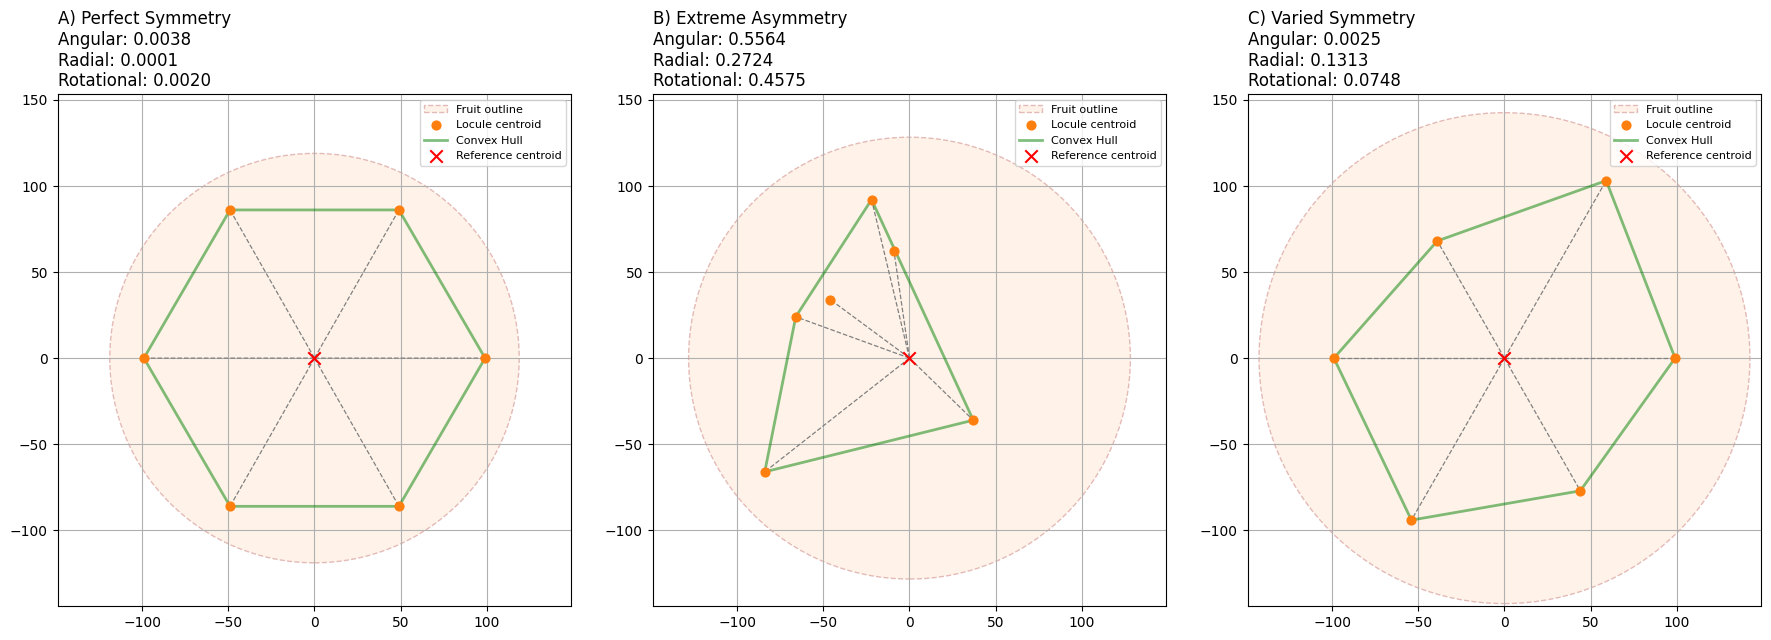

In [49]:

from matplotlib.patches import Ellipse, Polygon, Circle
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance
from scipy.stats import circmean
import math


# ----------------------------
# Generators (contours in correct format)
# ----------------------------
def create_locules_perfect(n=6, radius=100, center=(0, 0)):
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    contours = []
    for angle in angles:
        cx = center[0] + radius * math.cos(angle)
        cy = center[1] + radius * math.sin(angle)
        pts = np.array([
            [int(cx + 30 * math.cos(a)), int(cy + 30 * math.sin(a))] for a in np.linspace(0, 2*np.pi, 16, endpoint=False)
        ], dtype=np.int32).reshape((-1, 1, 2))
        contours.append(pts)
    locules = list(range(len(contours)))
    centroids = np.array([[c[:,0,0].mean(), c[:,0,1].mean()] for c in contours])
    centroid = tuple(centroids.mean(axis=0))
    return contours, locules, centroid

def create_locules_extreme(n=6, radius_range=(50, 150), center=(0, 0)):
    angles = np.random.uniform(0, 2*np.pi, n)
    radii = np.random.uniform(radius_range[0], radius_range[1], n)
    contours = []
    for angle, radius in zip(angles, radii):
        cx = center[0] + radius * math.cos(angle)
        cy = center[1] + radius * math.sin(angle)
        pts = np.array([
            [int(cx + 10 * math.cos(a)), int(cy + 10 * math.sin(a))] for a in np.linspace(0, 2*np.pi, 12, endpoint=False)
        ], dtype=np.int32).reshape((-1, 1, 2))
        contours.append(pts)
    locules = list(range(len(contours)))
    return contours, locules, center

def create_locules_varied(n=6, radius_list=None, center=(0, 0)):
    if radius_list is None:
        radius_list = [100, 120, 80, 100, 110, 90]
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    contours = []
    for angle, radius in zip(angles, radius_list):
        cx = center[0] + radius * math.cos(angle)
        cy = center[1] + radius * math.sin(angle)
        pts = np.array([
            [int(cx + 10 * math.cos(a)), int(cy + 10 * math.sin(a))] for a in np.linspace(0, 2*np.pi, 12, endpoint=False)
        ], dtype=np.int32).reshape((-1, 1, 2))
        contours.append(pts)
    locules = list(range(len(contours)))
    return contours, locules, center


def run_all_cases_with_fruit_shape(contours_list, locules_list, centroids_list, labels_list, margin=50, save_path=None):
    # Calcular límites comunes
    all_centroids = []
    for contours, locules, centroid in zip(contours_list, locules_list, centroids_list):
        locules_data = precalculate_locules_data(contours, locules, centroid)
        centroids_case = np.array([d['centroid'] for d in locules_data])
        if centroids_case.size > 0:
            all_centroids.append(centroids_case)

    if all_centroids:
        all_points = np.vstack(all_centroids)
        xmin, ymin = all_points.min(axis=0)
        xmax, ymax = all_points.max(axis=0)
        xmin -= margin
        xmax += margin
        ymin -= margin
        ymax += margin
    else:
        xmin, xmax, ymin, ymax = -margin, margin, -margin, margin

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for ax, contours, locules, centroid, label, subtitle in zip(
        axs, contours_list, locules_list, centroids_list, labels_list, ['A', 'B', 'C']
    ):
        locules_data = precalculate_locules_data(contours, locules, centroid)
        centroids = np.array([d['centroid'] for d in locules_data])
        
        angular_err = angular_normalized_error(locules_data)
        radial_err = radial_symmetry(locules_data)
        rotational_err = rotational_symmetry(locules_data, angle_error = angular_err)

        ax.set_aspect('equal')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.grid(True)

        # 1. Dibujar el círculo del fruto (exterior)
        if len(centroids) > 0:
            distances = distance.cdist([centroid], centroids)[0]
            fruit_radius = np.max(distances) * 1.2
            
            fruit_circle = Circle(centroid, fruit_radius, 
                                edgecolor='brown', 
                                facecolor='peachpuff', 
                                alpha=0.3, 
                                linestyle='--',
                                label='Fruit outline')
            ax.add_patch(fruit_circle)

        # 2. Dibujar los loculos y sus conexiones
        for i, d in enumerate(locules_data):
            pts = d['contour']
            
            cx, cy = d['centroid']
            # Punto naranja con etiqueta (solo para el primer loculo)
            ax.scatter(cx, cy, color='tab:orange', s=40, zorder=5, 
                      label='Locule centroid' if i == 0 else "")
            ax.plot([centroid[0], cx], [centroid[1], cy], color='gray', linestyle='--', linewidth=0.9)

        # 3. Dibujar polígono convexo
        if len(centroids) > 2:
            hull = ConvexHull(centroids)
            polygon = centroids[hull.vertices]
            ax.plot(np.append(polygon[:, 0], polygon[0, 0]), 
                   np.append(polygon[:, 1], polygon[0, 1]), 
                   'g-', lw=2, alpha=0.5, label='Convex Hull')



        # 5. Centroide de referencia
        ax.scatter(centroid[0], centroid[1], color='red', s=80, marker='x', label='Reference centroid', zorder=10)

        ax.set_title(f"{subtitle}) {label}\nAngular: {angular_err:.4f}\nRadial: {radial_err:.4f}\nRotational: {rotational_err:.4f}", 
                    fontsize=12, loc='left')
        ax.legend(fontsize=8, loc='upper right')

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()

# Ejemplo de uso
center = (0, 0)
contours_p, locs_p, cent_p = create_locules_perfect(center=center)
contours_e, locs_e, cent_e = create_locules_extreme(center=center)
contours_v, locs_v, cent_v = create_locules_varied(center=center)

run_all_cases_with_fruit_shape(
    [contours_p, contours_e, contours_v],
    [locs_p, locs_e, locs_v],
    [cent_p, cent_e, cent_v],
    ["Perfect Symmetry", "Extreme Asymmetry", "Varied Symmetry"],
    save_path='symmetry_analysis5.png'
)